In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.fftpack as fft
import scipy.signal as signal

from datetime import datetime


Cell for importing signal

115327 _wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=115327, comptype='NONE', compname='not compressed')


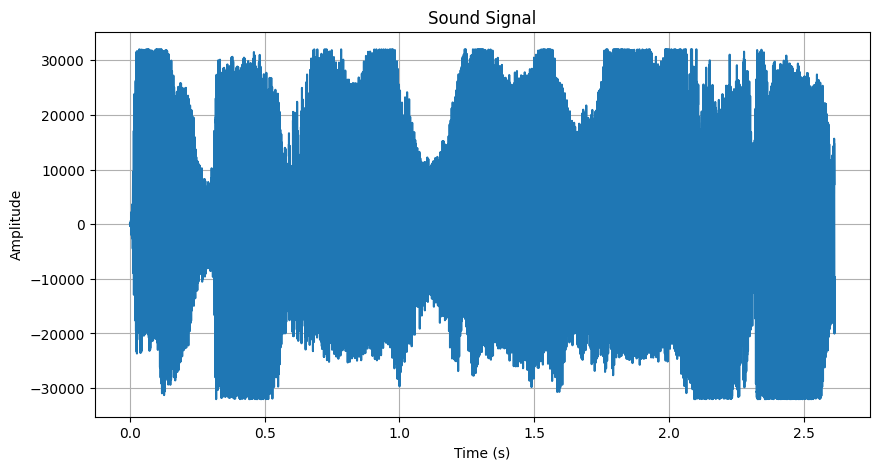

In [29]:
import matplotlib.pyplot as plt
import wave
# Open the WAV file
with wave.open('sample.wav', 'rb') as wav_file:
    # Get the sample rate and number of frames
    sample_rate = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    print(num_frames, wav_file.getparams())

    # Read the frames and convert them to a signal
    frames = wav_file.readframes(num_frames)
    signal = np.frombuffer(frames, dtype=np.int16)
    channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    frame_rate = wav_file.getframerate()

    # Calculate the duration of the signal in seconds

    length = num_frames / frame_rate
    
    time = np.linspace(0., length, num_frames)

    # Plot the signal in the time domain
    plt.figure(figsize=(10, 5))
    plt.plot(time,signal[:len(time)])
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Sound Signal')
    plt.savefig('report/unprocessed_signal.png')
    plt.show()


# Close the WAV file

Checking if signal length is valid

In [5]:
def check_length(signal):
    length = len(signal)
    next_power_of_two = 2 ** int(np.ceil(np.log2(length)))
    return np.pad(signal, (0, next_power_of_two - length), mode='constant')

def dft(signal):
    
    N = len(signal)
    
    C_k = np.zeros(N, dtype=np.complex_)
    
    for k in range(N):
        
        for n in range(N):
            C_k[k] += signal[n] * np.exp(-2j * np.pi * k * n / N)
        
        C_k[k] /= N
    return C_k


def idft(signal):
    
    N = len(signal)
    
    f_j = np.zeros(N, dtype=np.complex_)
    
    for j in range(N):
        
        for k in range(N):
            f_j[j] += signal[k] * np.exp(2j * np.pi * k * j / N)
        
    return f_j
        
    

def fft(signal):
    N = len(signal)
    
    if N <= 1:
        return signal
        
    fft_even = fft(signal[::2])
    fft_odd = fft(signal[1::2])
    
    k = np.arange(N // 2)
    W_n_k = np.exp(-2j * np.pi * k / N)
    
    A_k = fft_even
    B_k = fft_odd * W_n_k
    
    C_k = np.zeros(N, dtype=np.complex_)
    C_k[:N // 2] = A_k + B_k
    C_k[N // 2:] = A_k - B_k
    
    return C_k 


def ifft(signal):
    N = len(signal)
    
    if N <= 1:
        return signal
    
    ifft_even = ifft(signal[::2])
    ifft_odd = ifft(signal[1::2])
    
    k = np.arange(N // 2)
    W_n_k = np.exp(2j * np.pi * k / N)
    
    A_k = ifft_even
    B_k = ifft_odd * W_n_k
    
    f_j = np.zeros(N, dtype=np.complex_)
    f_j[:N // 2] = A_k + B_k
    f_j[N // 2:] = A_k - B_k
    
    return f_j/N

In [6]:
def plot_frequency_domain(signal, sampling_rate,outputfile):
    # Compute the FFT
    fft_result = fft(signal)
    
    # Compute the frequencies corresponding to the FFT result
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)
    
    # Compute the magnitude of the FFT result
    magnitudes = np.abs(fft_result)
    
    # Convert magnitudes to dB scale
    magnitudes_db = 20 * np.log10(magnitudes)
    
    # Plot the frequency domain
    plt.figure(figsize=(10, 5))
    plt.plot(freqs[:N // 2], magnitudes_db[:N // 2])  # Plot only the positive frequencies
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid()
    plt.savefig(outputfile)
    plt.show()

In [20]:
def plot_time_domain(signal, sampling_rate,output):
    # Generate the time axis
    N = len(signal)
    t = np.arange(N) / sampling_rate
    
    # Plot the time domain
    plt.figure(figsize=(12, 6))
    plt.plot(t, signal)
    plt.title('Time Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.savefig(output)
    plt.show()


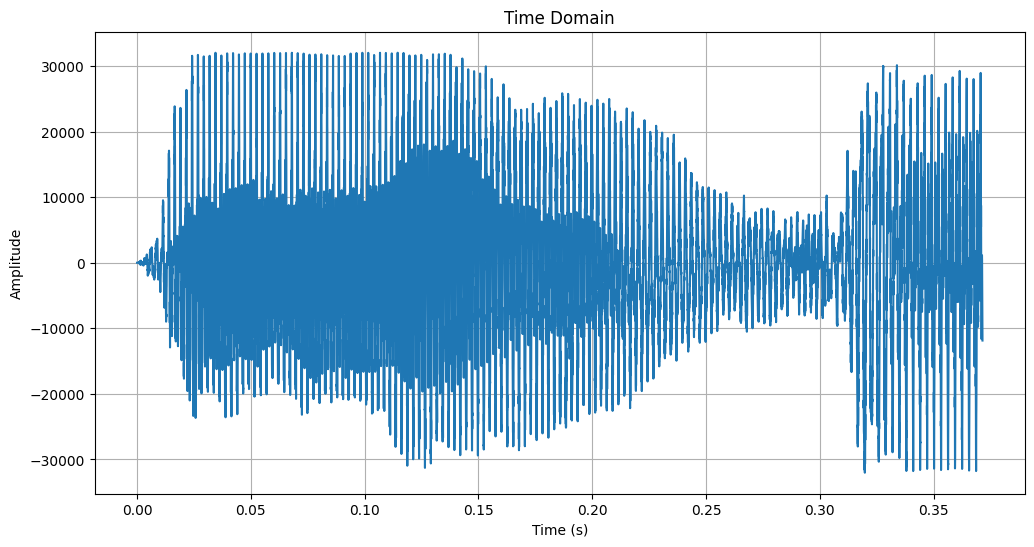

In [8]:
plot_time_domain(signal[:16384], sample_rate)

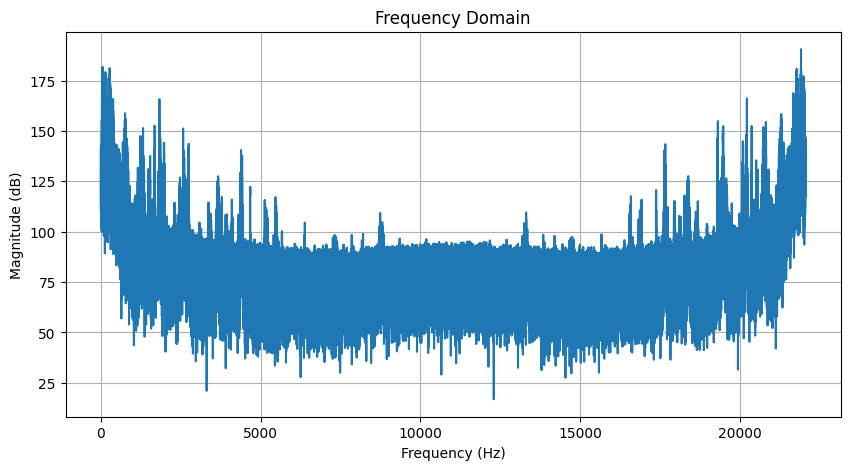

In [99]:
plot_frequency_domain(check_length(signal), sample_rate,outputfile='report/frequency_domain.png')

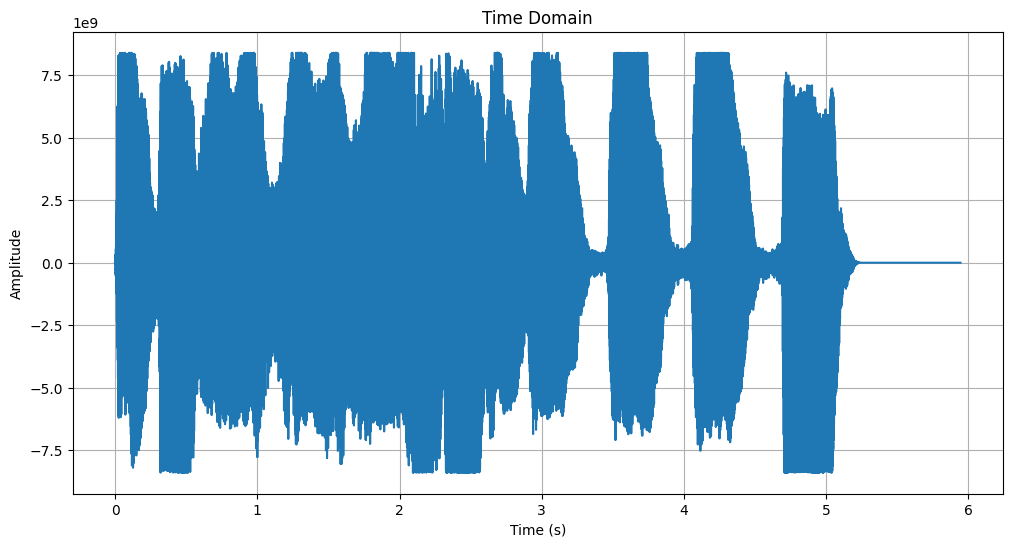

In [11]:
plot_time_domain(ifft(fft(check_length(signal))), sample_rate)

In [12]:
def denoise_signal(signal, sampling_rate, cutoff_frequency):
    # Compute the FFT
    fft_result = fft(signal)
    
    
    
    # Compute the frequencies corresponding to the FFT result
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)
    
    # Apply the low-pass filter
    fft_filtered = np.where(np.abs(freqs) > cutoff_frequency, 0, fft_result)
    
    
    # Compute the magnitude of the FFT result
    magnitudes = np.abs(fft_filtered)
    
    # Convert magnitudes to dB scale
    magnitudes_db = 20 * np.log10(magnitudes)
    
    # Plot the frequency domain
    plt.figure(figsize=(12, 6))
    plt.plot(freqs[:N // 2], magnitudes_db[:N // 2])  # Plot only the positive frequencies
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid()
    plt.show()
    
    # Compute the inverse FFT
    filtered_signal = ifft(fft_filtered)
    
    return filtered_signal.real

In [9]:
def output_sound(signal, sample_rate, sample_width, channels):
    # Set the parameters for the WAV file
    params = (channels, sample_width, sample_rate, len(signal), 'NONE', 'not compressed')
    
    # Scale the signal to match the range of 16-bit PCM
    scaled_signal = (signal / np.max(np.abs(signal))) * 32767
    
    # If the signal has only one channel, convert it to stereo by duplicating the channel
    if channels == 1:
        scaled_signal = np.column_stack((scaled_signal, scaled_signal))
    
    # Convert the signal to the appropriate data type
    scaled_signal = scaled_signal.astype(np.int16)
    
    # Create a new WAV file
    with wave.open('output.wav', 'w') as wav_file:
        # Set the WAV file parameters
        wav_file.setnchannels(channels)
        wav_file.setsampwidth(sample_width)
        wav_file.setframerate(sample_rate)
        
        # Write the signal to the WAV file
        wav_file.writeframes(scaled_signal.tobytes())
    
    return None


In [131]:
#compare speed of dft and fft

#generate random signal in power of 2 starting from 2^6 to 2^12

signal_lengths = [2**i for i in range(2, 8)]
dft_times = []
fft_times = []

for length in signal_lengths:
    signal = np.random.rand(length)
    
    start_time = datetime.now()
    dft(signal)
    end_time = datetime.now()
    dft_times.append((end_time - start_time).total_seconds())
    
    start_time = datetime.now()
    fft(signal)
    end_time = datetime.now()
    fft_times.append((end_time - start_time).total_seconds())
    

In [132]:
dft_times, fft_times


([5e-05, 8.9e-05, 0.000328, 0.001459, 0.005903, 0.021828],
 [9.5e-05, 0.000313, 0.000216, 0.000342, 0.000624, 0.001148])

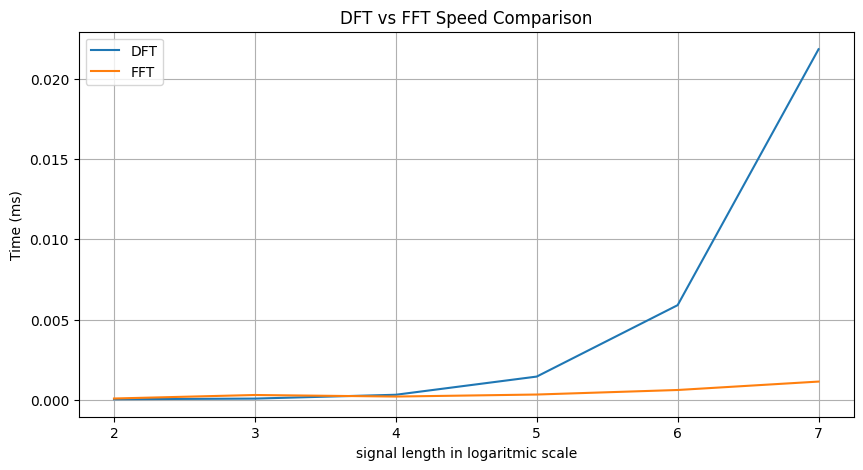

In [133]:
plt.figure(figsize=(10, 5))
plt.plot(np.log2(signal_lengths), dft_times, label='DFT')
plt.plot(np.log2(signal_lengths), fft_times, label='FFT')

plt.grid()
plt.legend()
plt.title('DFT vs FFT Speed Comparison')
plt.xlabel('signal length in logaritmic scale')
plt.ylabel('Time (ms)')
plt.savefig('report/dft_vs_fft.png')

In [152]:
signal_lengths = [2**i for i in range(2, 17)]
np_fft_times = []
fft_times = []

for length in signal_lengths:
    signal = np.random.rand(length)
    
    start_time = datetime.now()
    np.fft.fft(signal)
    end_time = datetime.now()
    np_fft_times.append((end_time - start_time).total_seconds())
    
    start_time = datetime.now()
    fft(signal)
    end_time = datetime.now()
    fft_times.append((end_time - start_time).total_seconds())

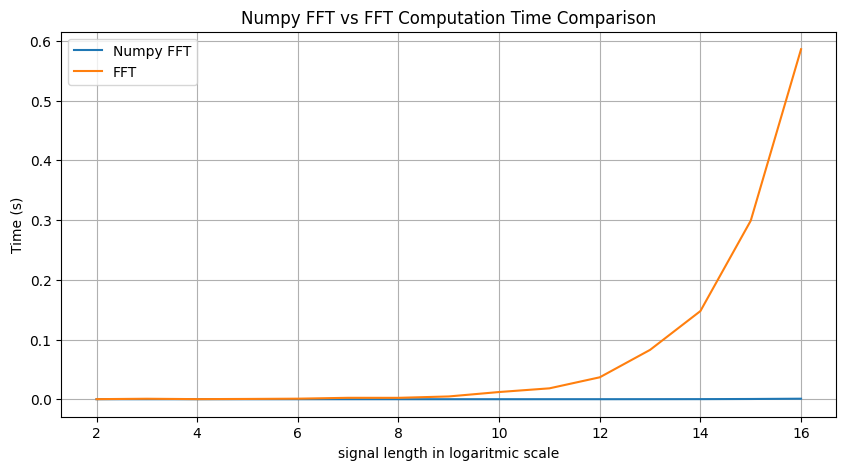

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(np.log2(signal_lengths), np_fft_times, label='Numpy FFT')
plt.plot(np.log2(signal_lengths), fft_times, label='FFT')

plt.grid()
plt.legend()
plt.title('Numpy FFT vs FFT Computation Time Comparison')
plt.xlabel('signal length in logaritmic scale')
plt.ylabel('Time (s)')
plt.savefig('report/np_fft_fft.png')

In [155]:
signal_lengths = [2**i for i in range(2, 17)]
zerop_fft_times = []
fft_times = []

for length in signal_lengths:
    signal = np.random.rand(length)
    
    start_time = datetime.now()
    fft(check_length(np.append(signal,0)))
    end_time = datetime.now()
    zerop_fft_times.append((end_time - start_time).total_seconds())
    
    start_time = datetime.now()
    fft(signal)
    end_time = datetime.now()
    fft_times.append((end_time - start_time).total_seconds())

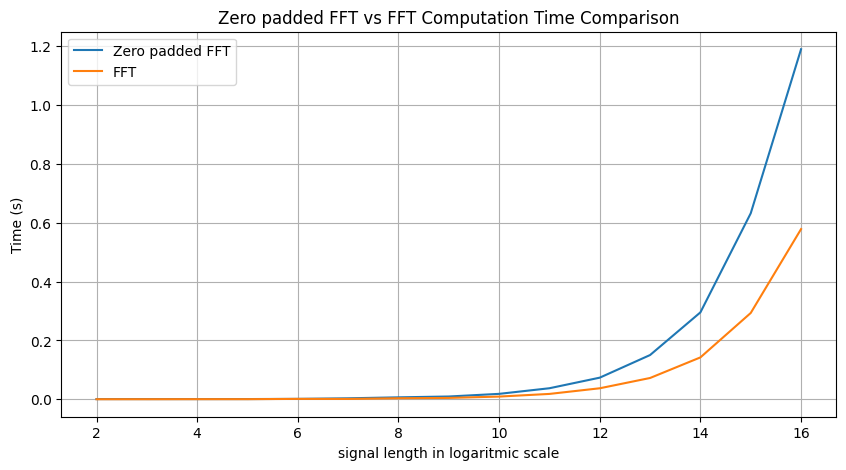

In [158]:
plt.figure(figsize=(10, 5))
plt.plot(np.log2(signal_lengths), zerop_fft_times, label='Zero padded FFT')
plt.plot(np.log2(signal_lengths), fft_times, label='FFT')

plt.grid()
plt.legend()
plt.title('Zero padded FFT vs FFT Computation Time Comparison')
plt.xlabel('signal length in logaritmic scale')
plt.ylabel('Time (s)')
plt.savefig('report/zerop_fft_fft.png')

In [13]:
from scipy.fft import fft, fftfreq


def plot_frequency_histogram(signal, sampling_rate, outputfile):
    N = len(signal)
    freq_bins = fftfreq(N, d=1/sampling_rate)
    fft_signal = fft(signal)
    magnitudes = np.abs(fft_signal)
    
    plt.figure(figsize=(10, 6))
    plt.hist(freq_bins[:N // 2], bins=50, weights=magnitudes[:N // 2])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum Histogram')
    plt.grid(True)
    plt.savefig(outputfile)
    plt.show()

    
    
    
    
def low_pass_filter(signal, sampling_rate, cutoff_freq):
    # Compute the FFT of the signal
    fft_signal = fft(signal)
    
    # Compute the frequency bins
    N = len(signal)
    freq_bins = fftfreq(N, d=1/sampling_rate)
    
    # Create a filter mask to keep frequencies below the cutoff frequency
    filter_mask = np.abs(freq_bins) <= cutoff_freq
    
    # Apply the filter mask to the FFT result
    filtered_fft_signal = fft_signal * filter_mask
    
    plot_frequency_histogram(filtered_fft_signal, sampling_rate, outputfile='low_pass_spectrum_histogram.png')
    # Compute the inverse FFT to obtain the filtered signal
    filtered_signal = np.real(ifft(filtered_fft_signal))
    
    
    return filtered_signal

def high_pass_filter(signal, sampling_rate, cutoff_freq):
    # Compute the FFT of the signal
    fft_signal = fft(signal)
    
    # Compute the frequency bins
    N = len(signal)
    freq_bins = fftfreq(N, d=1/sampling_rate)
    
    # Create a filter mask to keep frequencies above the cutoff frequency
    filter_mask = np.abs(freq_bins) >= cutoff_freq
    
    # Apply the filter mask to the FFT result
    filtered_fft_signal = fft_signal * filter_mask
    
    # Compute the inverse FFT to obtain the filtered signal
    plot_frequency_histogram(filtered_fft_signal, sampling_rate, outputfile='high_pass_spectrum_histogram.png')
    filtered_signal = np.real(ifft(filtered_fft_signal))
    
    
    return filtered_signal

def band_pass_filter(signal, sampling_rate, freq_range,output):
    # Compute the FFT of the signal
    fft_signal = fft(signal)
    
    # Compute the frequency bins
    N = len(signal)
    freq_bins = fftfreq(N, d=1/sampling_rate)
    
    # Define the frequency range to be passed
    low_freq, high_freq = freq_range
    
    # Create a filter mask to keep frequencies within the specified range
    filter_mask = np.logical_and(freq_bins >= low_freq, freq_bins <= high_freq)
    
    # Apply the filter mask to the FFT result
    filtered_fft_signal = fft_signal * filter_mask
    
    # Compute the inverse FFT to obtain the filtered signal
    filtered_signal = np.real(ifft(filtered_fft_signal))
    
    plot_frequency_histogram(filtered_signal, sampling_rate, outputfile=output)
    
    return filtered_signal 


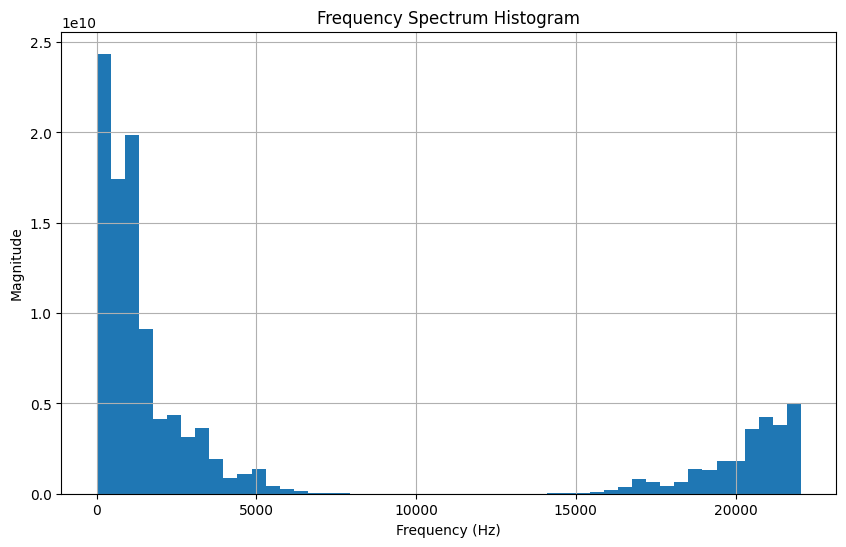

In [174]:
plot_frequency_histogram(signal, sample_rate, outputfile='original_spectrum_histogram.png')

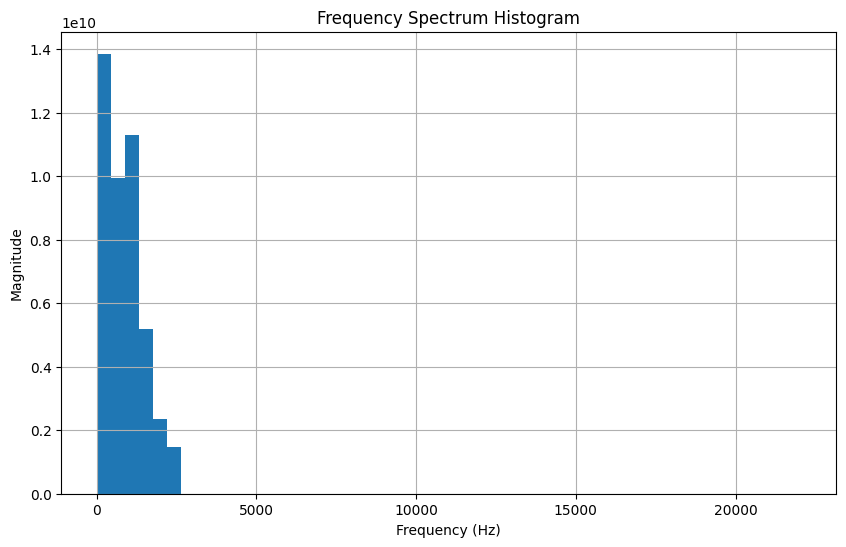

In [171]:
result = band_pass_filter(check_length(signal), sample_rate, (0, 2500))

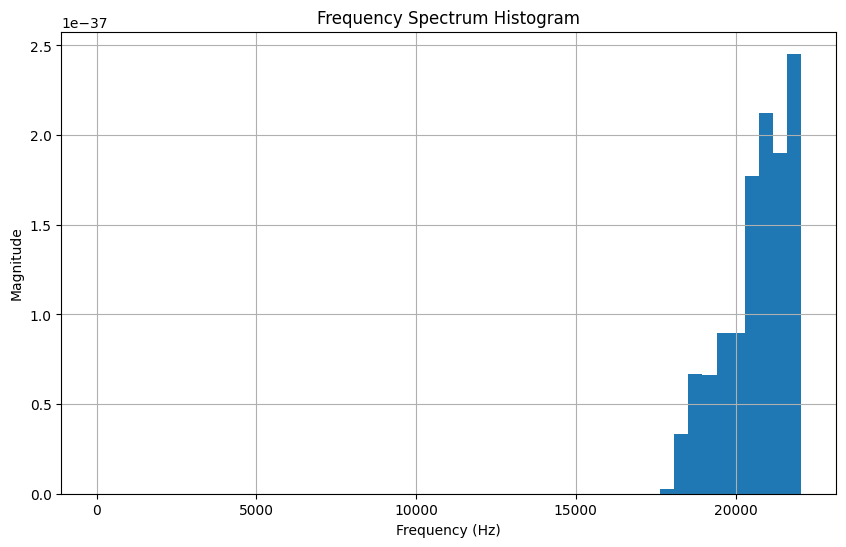

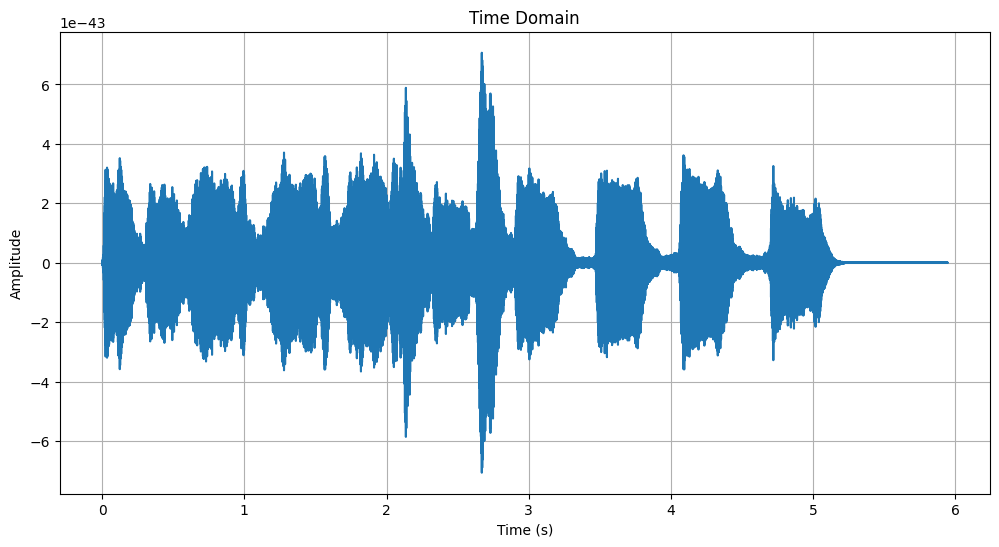

In [26]:
result = band_pass_filter(check_length(signal), sample_rate, (18000, 25000),output='report/high_pass_filtered_spectrum_histogram.png')

output_sound(result, sample_rate, sample_width, channels)

plot_time_domain(result, sample_rate,output='report/high_pass_time_domain.png')

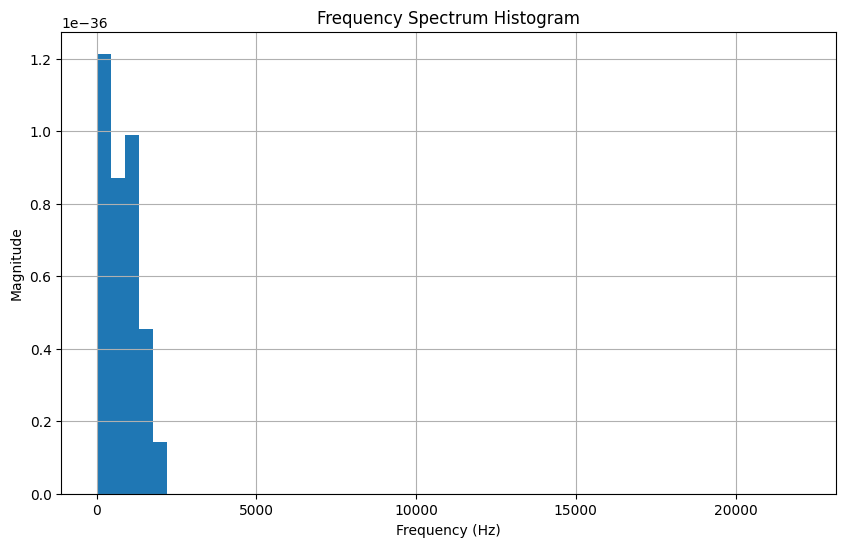

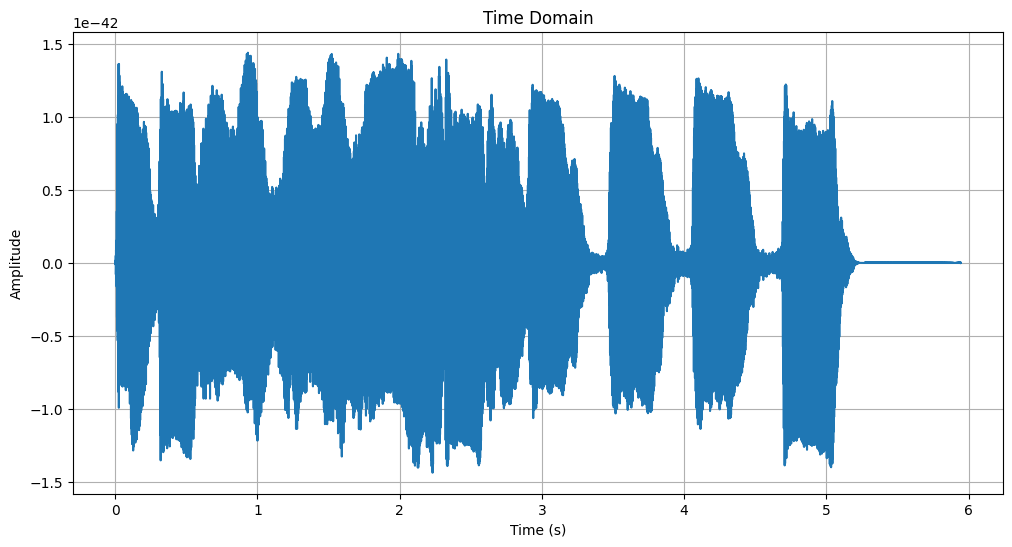

In [23]:
result = band_pass_filter(check_length(signal), sample_rate, (0, 2000),output='report/low_pass_filter.png')

output_sound(result, sample_rate, sample_width, channels)

plot_time_domain(result, sample_rate,output='report/low_pass_filter_time_domain.png')

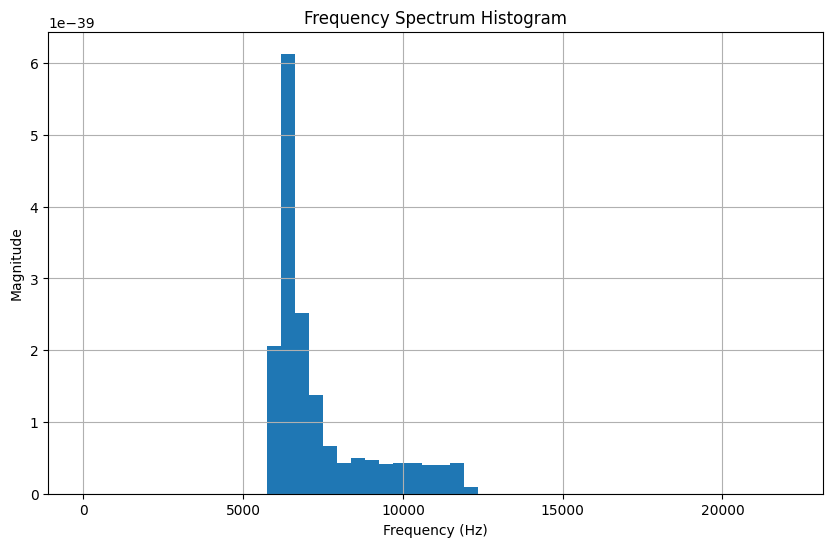

In [16]:
result = band_pass_filter(check_length(signal), sample_rate, (6000, 12000),output='report/mid_pass_filter.png')

output_sound(result, sample_rate, sample_width, channels)

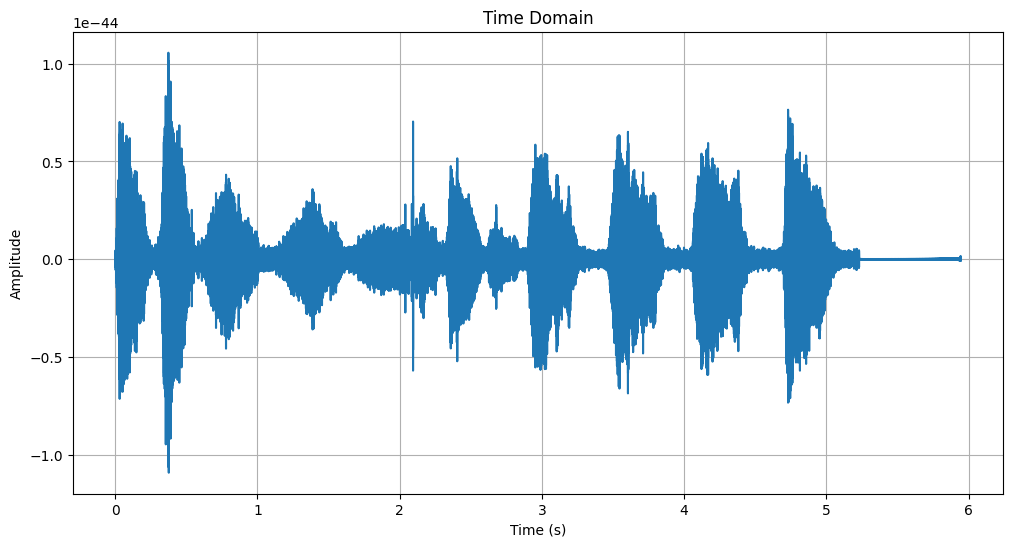

In [21]:
plot_time_domain(result, sample_rate,'report/mid_pass_filter_time.png')

741161 _wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=741161, comptype='NONE', compname='not compressed')


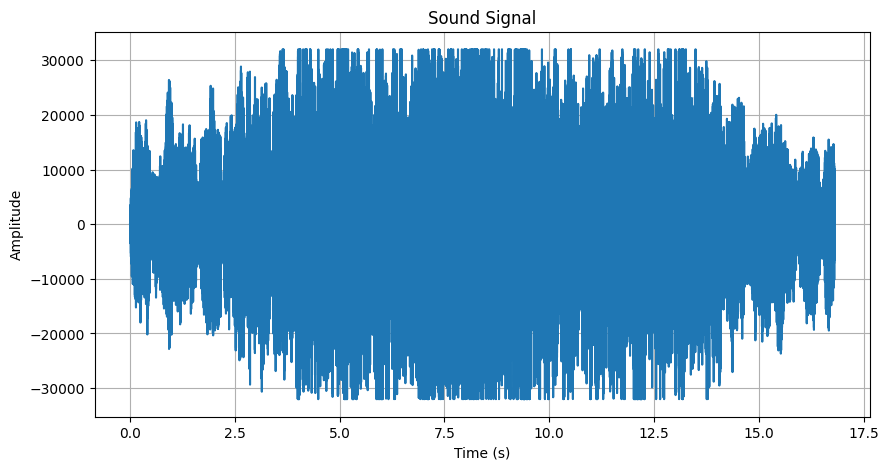

In [30]:
with wave.open('test1.wav', 'rb') as wav_file:
    # Get the sample rate and number of frames
    sample_rate = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    print(num_frames, wav_file.getparams())

    # Read the frames and convert them to a signal
    frames = wav_file.readframes(num_frames)
    signal = np.frombuffer(frames, dtype=np.int16)
    channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    frame_rate = wav_file.getframerate()

    # Calculate the duration of the signal in seconds

    length = num_frames / frame_rate
    
    time = np.linspace(0., length, num_frames)

    # Plot the signal in the time domain
    plt.figure(figsize=(10, 5))
    plt.plot(time,signal[:len(time)])
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Sound Signal')
    plt.savefig('report/ex2_raw.png')
    plt.show()


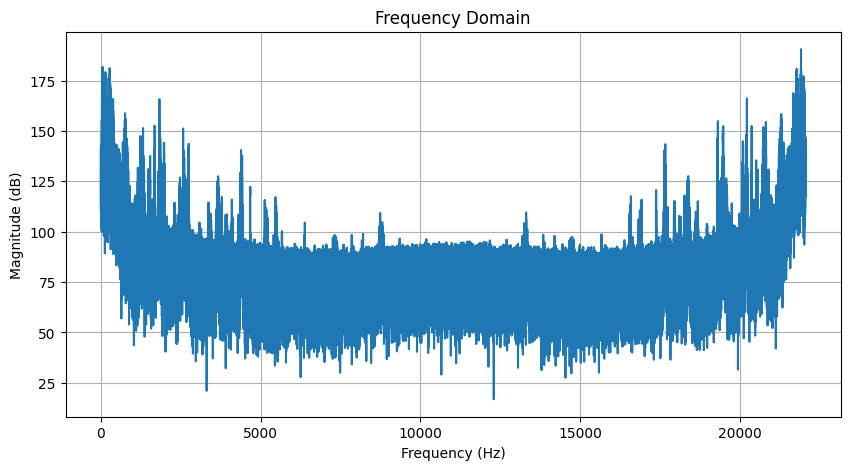

In [31]:
plot_frequency_domain(check_length(signal), sample_rate,outputfile='report/ex2_frequency_domain.png')

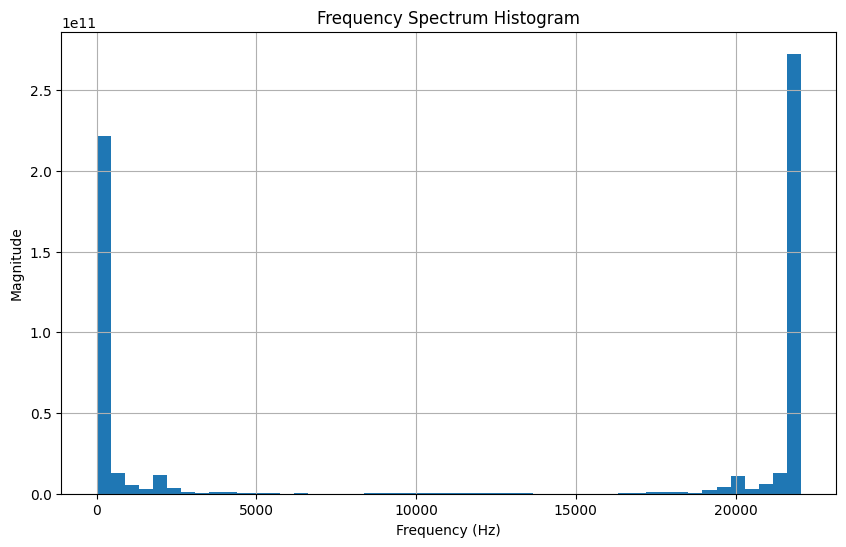

In [32]:
plot_frequency_histogram(signal, sample_rate, outputfile='report/ex2_spectrum_histogram.png')

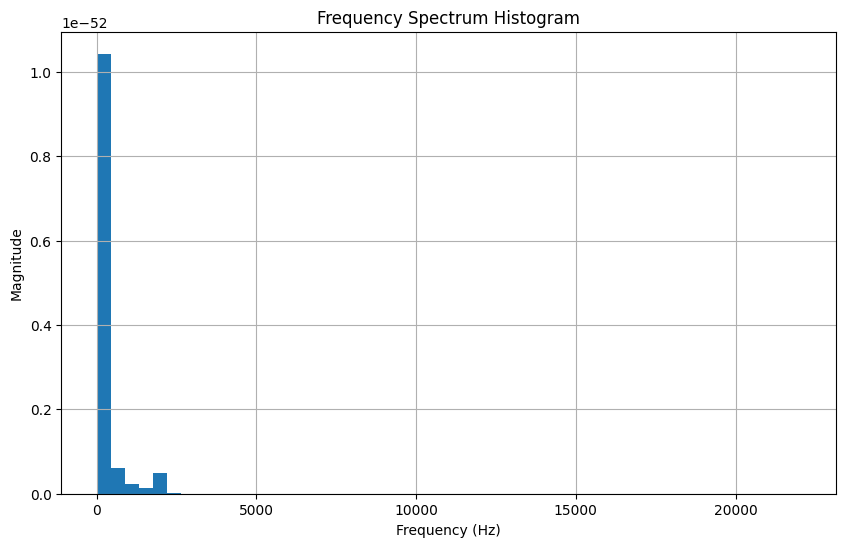

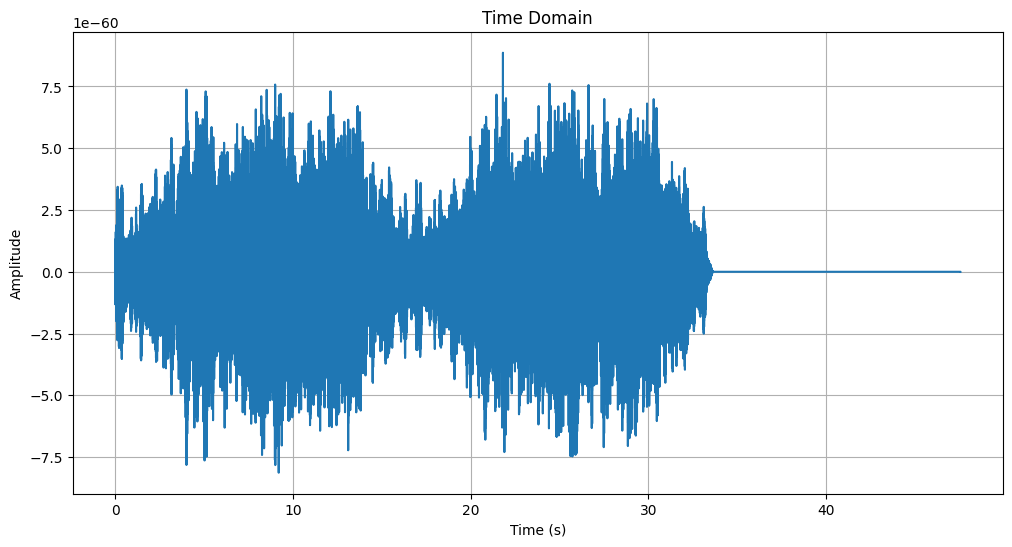

In [34]:
result = band_pass_filter(check_length(signal), sample_rate, (0, 2500),output='report/ex2_low_pass_filter.png')

output_sound(result, sample_rate, sample_width, channels)

plot_time_domain(result, sample_rate,output='report/ex2_low_pass_filter_time_domain.png')

2120644 _wave_params(nchannels=2, sampwidth=3, framerate=44100, nframes=2120644, comptype='NONE', compname='not compressed')


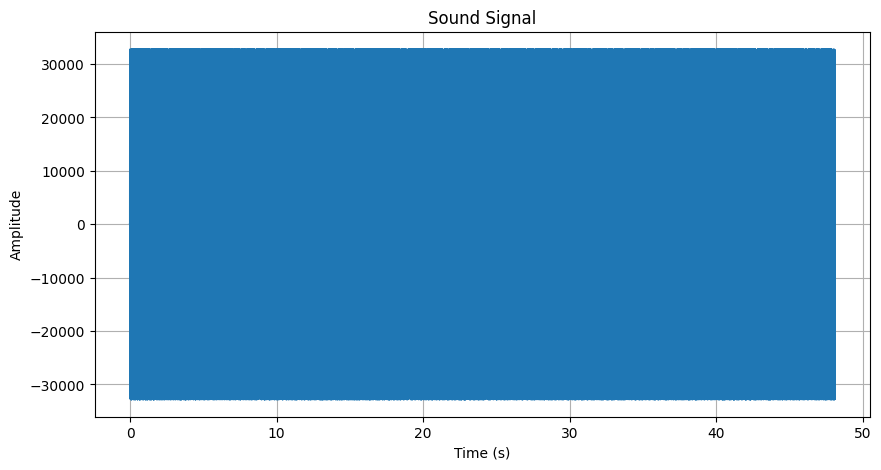

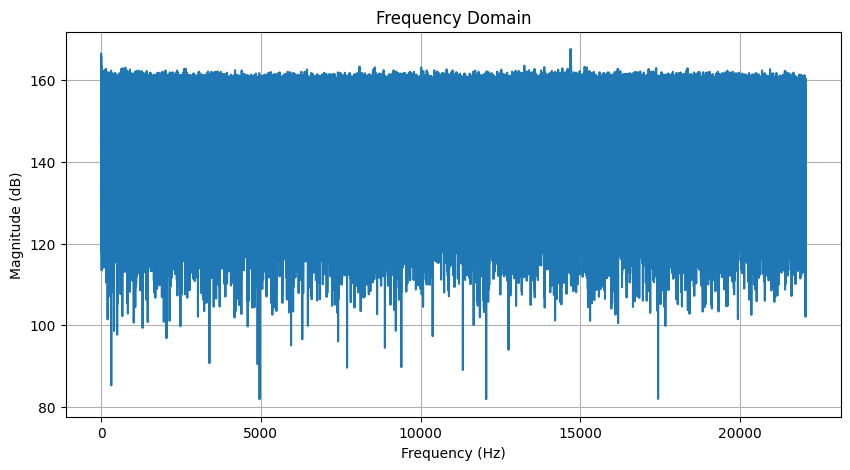

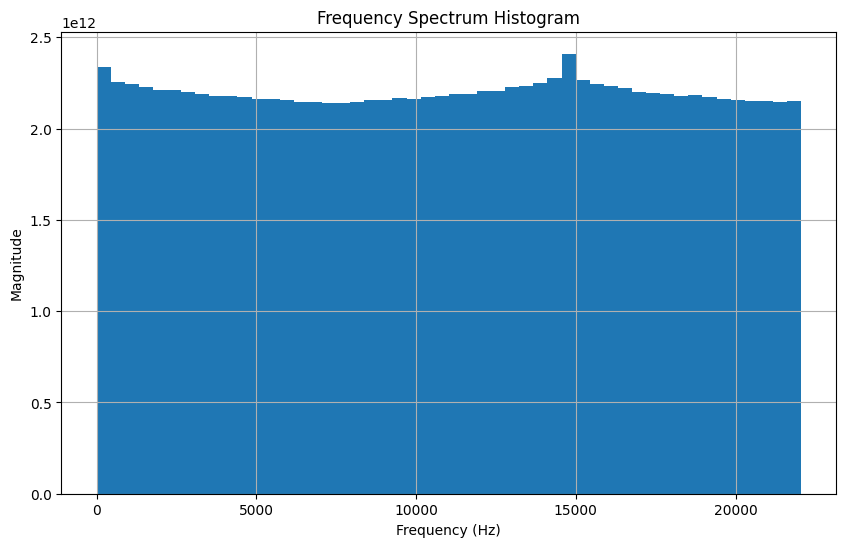

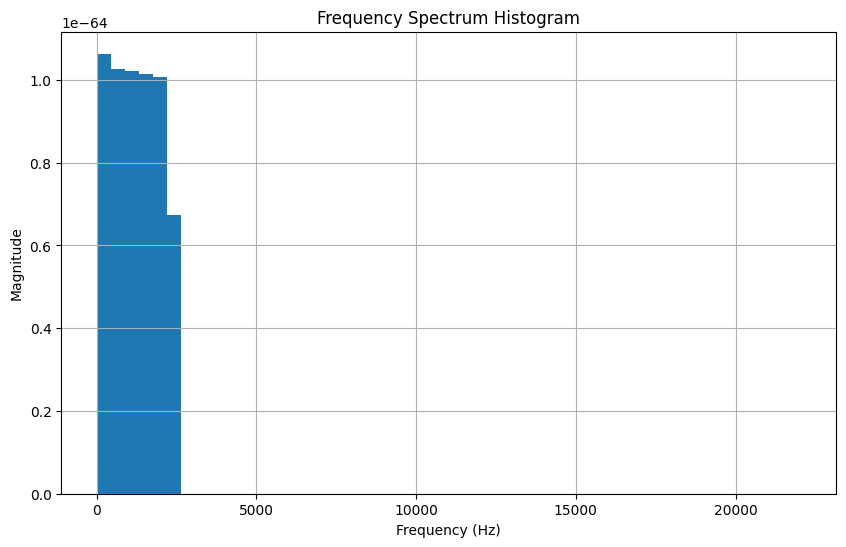

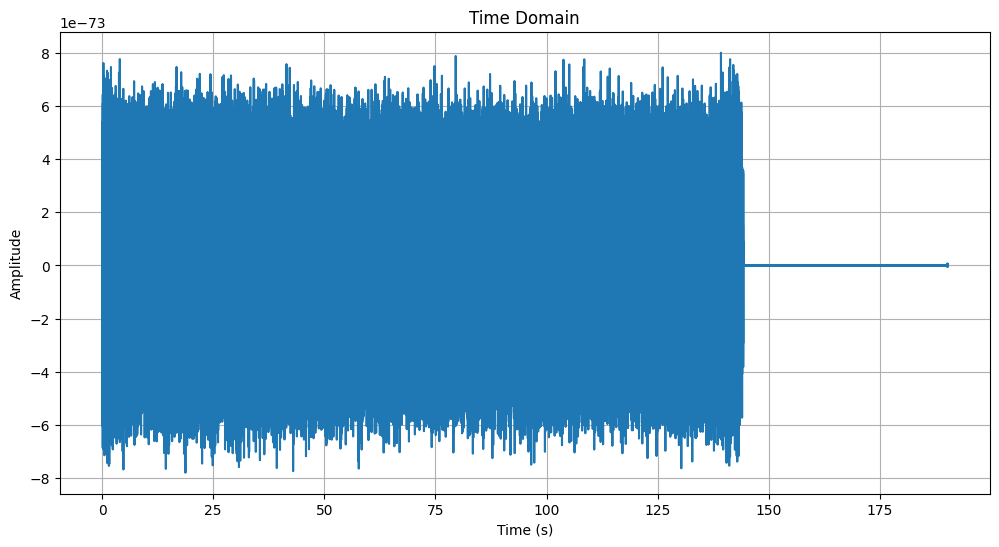

In [35]:
with wave.open('test2.wav', 'rb') as wav_file:
    # Get the sample rate and number of frames
    sample_rate = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    print(num_frames, wav_file.getparams())

    # Read the frames and convert them to a signal
    frames = wav_file.readframes(num_frames)
    signal = np.frombuffer(frames, dtype=np.int16)
    channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    frame_rate = wav_file.getframerate()

    # Calculate the duration of the signal in seconds

    length = num_frames / frame_rate
    
    time = np.linspace(0., length, num_frames)

    # Plot the signal in the time domain
    plt.figure(figsize=(10, 5))
    plt.plot(time,signal[:len(time)])
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Sound Signal')
    plt.savefig('report/ex3_raw.png')
    plt.show()
    
plot_frequency_domain(check_length(signal), sample_rate,outputfile='report/ex3_frequency_domain.png')    
plot_frequency_histogram(signal, sample_rate, outputfile='report/ex3_spectrum_histogram.png')

result = band_pass_filter(check_length(signal), sample_rate, (0, 2500),output='report/ex3_low_pass_filter.png')

output_sound(result, sample_rate, sample_width, channels)

plot_time_domain(result, sample_rate,output='report/ex3_low_pass_filter_time_domain.png')

12870 _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=12870, comptype='NONE', compname='not compressed')


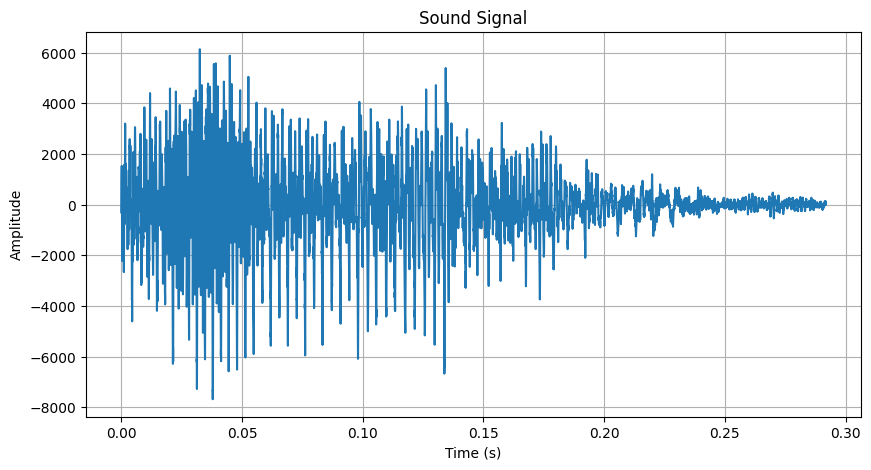

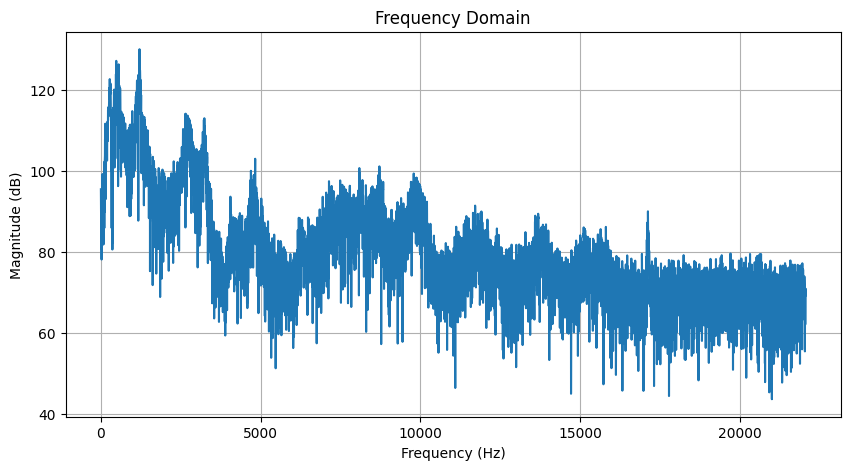

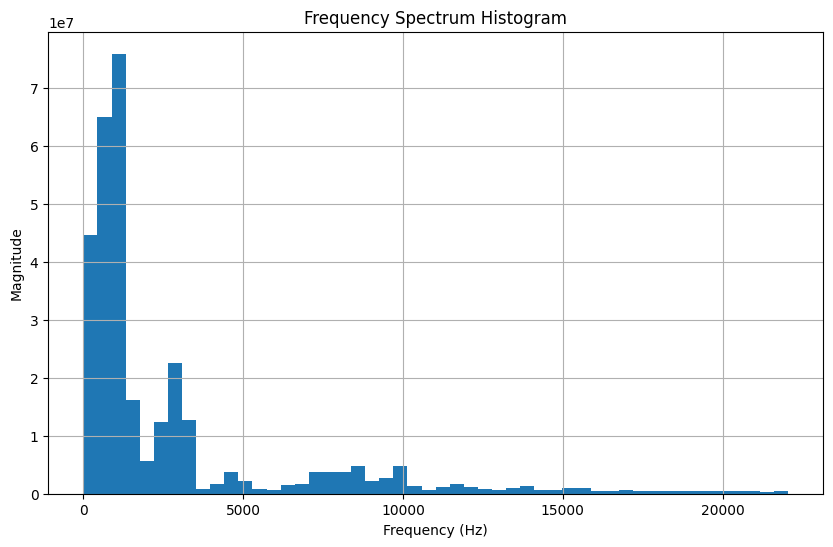

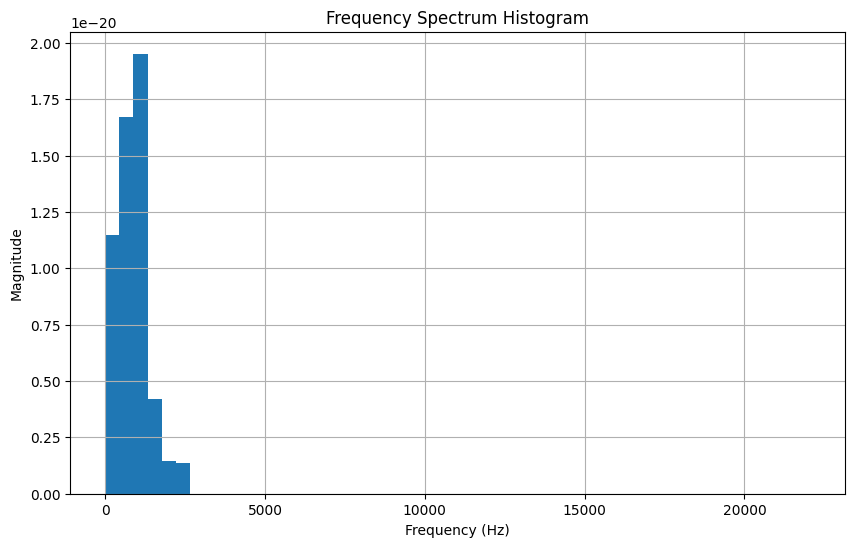

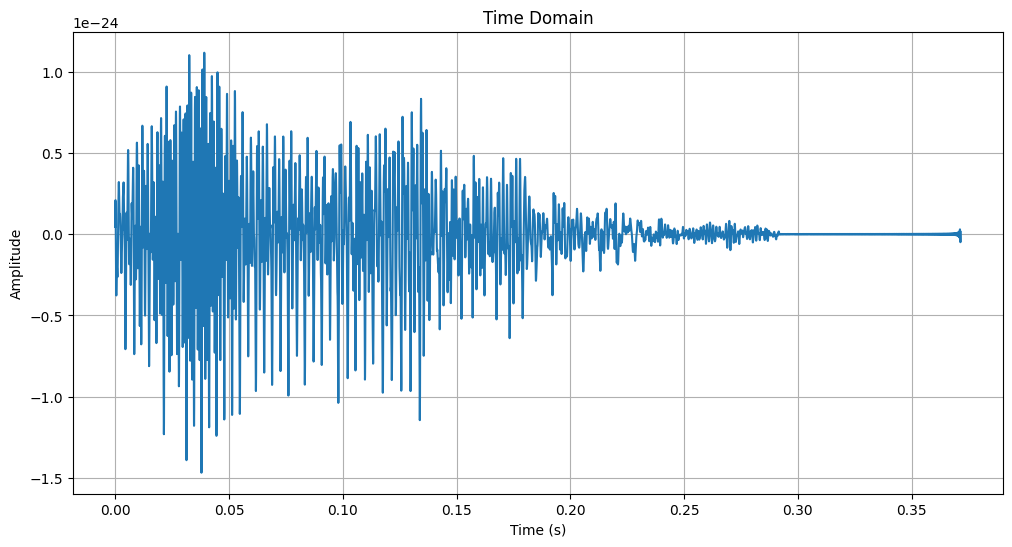

In [36]:
with wave.open('test3.wav', 'rb') as wav_file:
    # Get the sample rate and number of frames
    sample_rate = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    print(num_frames, wav_file.getparams())

    # Read the frames and convert them to a signal
    frames = wav_file.readframes(num_frames)
    signal = np.frombuffer(frames, dtype=np.int16)
    channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    frame_rate = wav_file.getframerate()

    # Calculate the duration of the signal in seconds

    length = num_frames / frame_rate
    
    time = np.linspace(0., length, num_frames)

    # Plot the signal in the time domain
    plt.figure(figsize=(10, 5))
    plt.plot(time,signal[:len(time)])
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Sound Signal')
    plt.savefig('report/ex4_raw.png')
    plt.show()
    
plot_frequency_domain(check_length(signal), sample_rate,outputfile='report/ex4_frequency_domain.png')    
plot_frequency_histogram(signal, sample_rate, outputfile='report/ex4_spectrum_histogram.png')

result = band_pass_filter(check_length(signal), sample_rate, (0, 2500),output='report/ex4_low_pass_filter.png')

output_sound(result, sample_rate, sample_width, channels)

plot_time_domain(result, sample_rate,output='report/ex4_low_pass_filter_time_domain.png')

78642 _wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=78642, comptype='NONE', compname='not compressed')


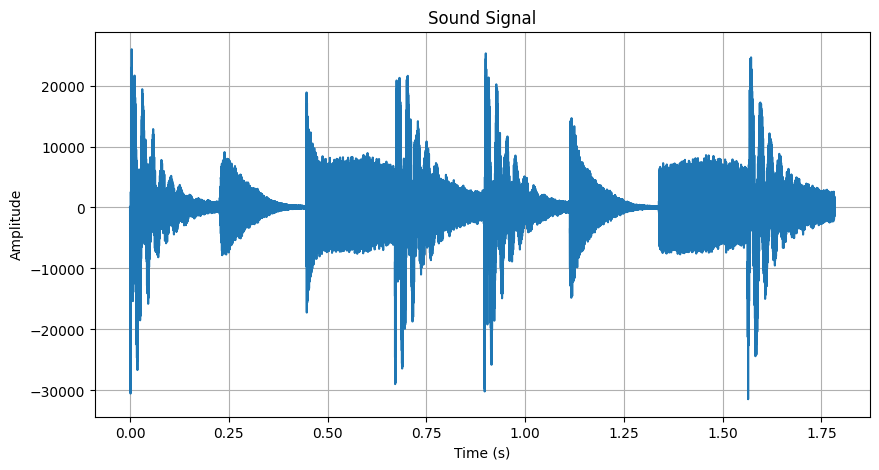

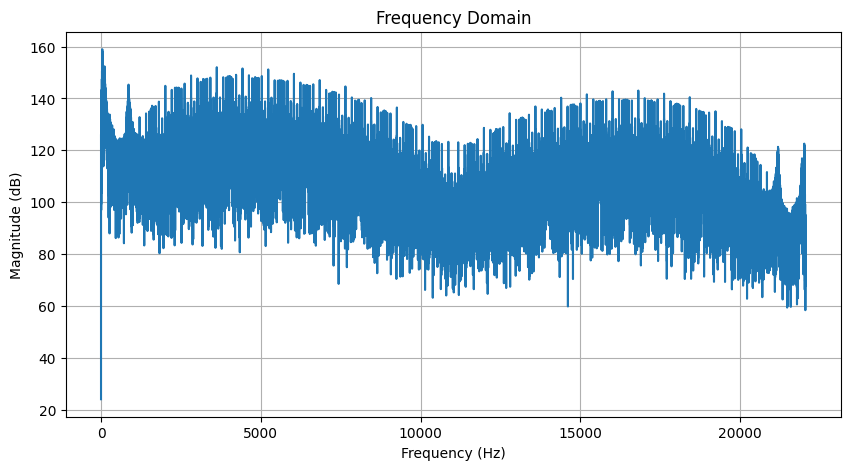

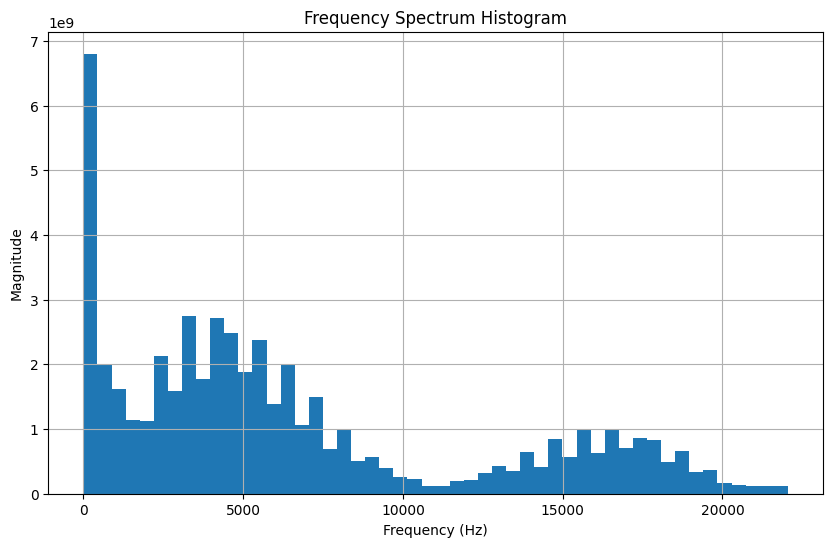

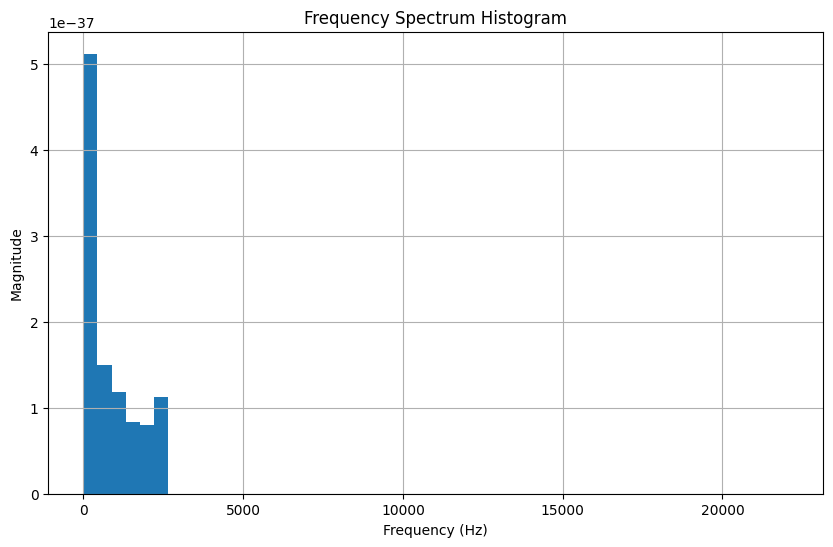

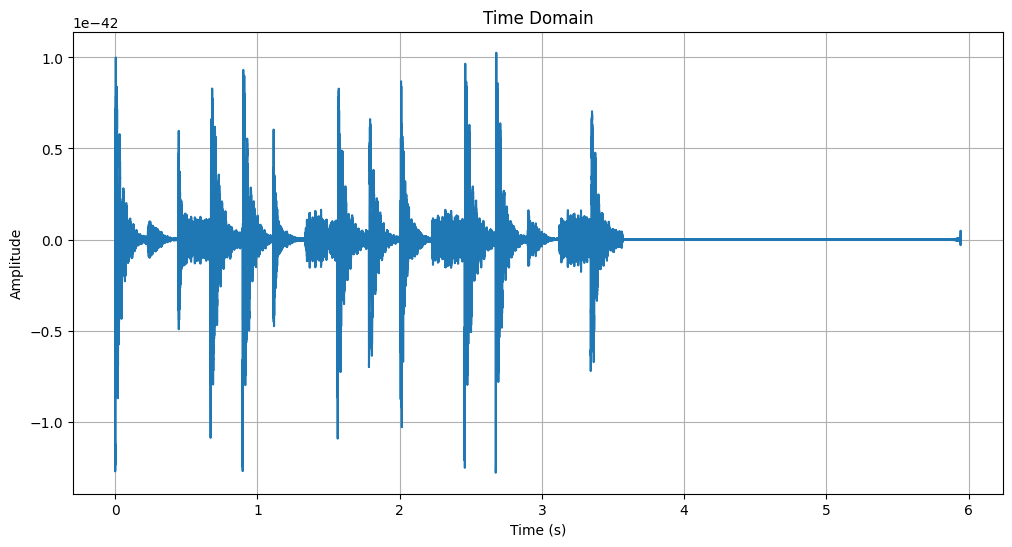

In [37]:
with wave.open('test4.wav', 'rb') as wav_file:
    # Get the sample rate and number of frames
    sample_rate = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    print(num_frames, wav_file.getparams())

    # Read the frames and convert them to a signal
    frames = wav_file.readframes(num_frames)
    signal = np.frombuffer(frames, dtype=np.int16)
    channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    frame_rate = wav_file.getframerate()

    # Calculate the duration of the signal in seconds

    length = num_frames / frame_rate
    
    time = np.linspace(0., length, num_frames)

    # Plot the signal in the time domain
    plt.figure(figsize=(10, 5))
    plt.plot(time,signal[:len(time)])
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Sound Signal')
    plt.savefig('report/ex5_raw.png')
    plt.show()
    
plot_frequency_domain(check_length(signal), sample_rate,outputfile='report/ex5_frequency_domain.png')    
plot_frequency_histogram(signal, sample_rate, outputfile='report/ex5_spectrum_histogram.png')

result = band_pass_filter(check_length(signal), sample_rate, (0, 2500),output='report/ex5_low_pass_filter.png')

output_sound(result, sample_rate, sample_width, channels)

plot_time_domain(result, sample_rate,output='report/ex5_low_pass_filter_time_domain.png')